In [37]:
# imports and basic notebook setup
import sys
import math
sys.path.append("/home/mikael/caffe/distribute/python")

from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

## Loading DNN model
In this notebook we are going to use a [GoogLeNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) model trained on [ImageNet](http://www.image-net.org/) dataset.
Feel free to experiment with other models from Caffe [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). One particularly interesting [model](http://places.csail.mit.edu/downloadCNN.html) was trained in [MIT Places](http://places.csail.mit.edu/) dataset. It produced many visuals from the [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [38]:
model_path = '/home/mikael/Downloads/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0), # the reference model has channels in BGR order instead of RGB
                      raw_scale=255) 

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [39]:


def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    



Next we implement an ascent through different scales. We call these scales "octaves".

In [40]:
def deepdream(net, base_img, iter_n=20, octave_n=6, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

Now we are ready to let the neural network to reveal its dreams! Let's take a [cloud image](https://commons.wikimedia.org/wiki/File:Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG) as a starting point:

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

Initial size:  11169972   2526 x 4422
Final size:  399608   478 x 836


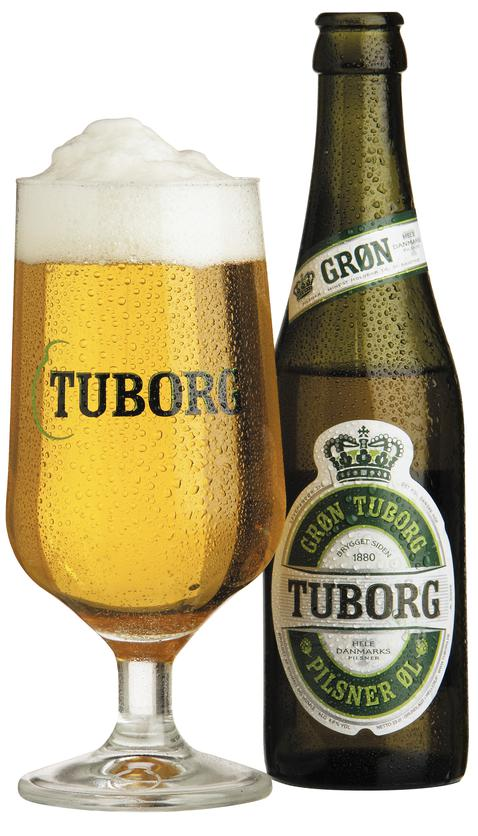

In [41]:
def loadWithMaxSize(imagename, maxSize = 400000):
    ig = PIL.Image.open(imagename)
    dim = ig.size[0]*ig.size[1]
    print "Initial size: ", dim, " ", ig.size[0], "x", ig.size[1]
    factor = math.sqrt(float(maxSize)/dim)
    ig = ig.resize((int(factor*ig.size[0]),int(factor*ig.size[1])), PIL.Image.ANTIALIAS)
    dim = ig.size[0]*ig.size[1]
    print "Final size: ", dim, " ", ig.size[0], "x", ig.size[1]
    return ig

imagename = '/home/mikael/Downloads/t2.jpg'
img = np.float32(loadWithMaxSize(imagename))
showarray(img)

In [42]:
caffe.set_mode_gpu()

with open("/home/mikael/Downloads/synset_words.txt") as f:
    labels = f.readlines()
        
input_image = caffe.io.load_image(imagename)
prediction = net.predict([input_image], oversample=False)
top5predictions = prediction[0].argsort()[-5:][::-1] 

for p in top5predictions:
    print "Predicted class:", labels[p].strip('\n').split(' ', 1)[1], " (", "{:.3f}".format(100*prediction[0][p]), "%)"



Predicted class: beer glass  ( 50.375 %)
Predicted class: beer bottle  ( 47.401 %)
Predicted class: goblet  ( 1.185 %)
Predicted class: pop bottle, soda bottle  ( 0.483 %)
Predicted class: eggnog  ( 0.136 %)


Initial size:  11169972   2526 x 4422
Final size:  199758   338 x 591


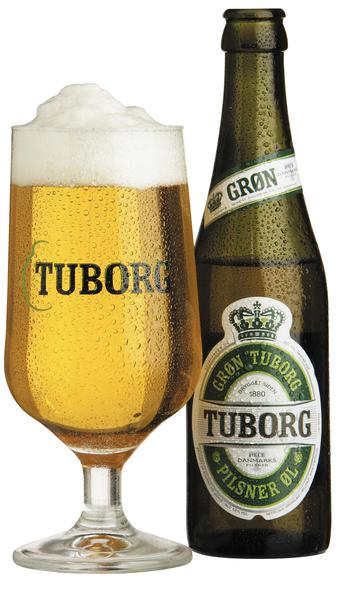

In [43]:

guide = np.float32(loadWithMaxSize('/home/mikael/Downloads/t2.jpg',maxSize = 200000))
showarray(guide)
    

In [44]:
end = 'inception_4c/output'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

In [45]:


def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    print A.argmax(1)
    dst.diff[0].reshape(ch,-1)[:] = x[:,(1)] # select ones that match best

_=deepdream(net, img, end=end, objective=objective_guide)



[735  15  12  17  16  13  15  15 432  36  14  36  37 222  57  35  36  36
 453  57 714 603 603 432  15 714  57 724 474 414 735 593 594 474 603 525
 593 615 715 645 735 677 698 756 736]


ValueError: could not broadcast input array from shape (512) into shape (512,45)

The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling:

We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. You can modify the `make_step` function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

What if we feed the `deepdream` function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

Be careful running the code above, it can bring you into very strange realms!